# Plot Resistivity Uncertainty using Coefficient of Variation

This notebook visualizes the relative uncertainty in resistivity predictions across different depths using the coefficient of variation (CV = uncertainty / predicted_resistivity).

The CV approach is more appropriate than absolute uncertainty because:
- Resistivity varies from 100 to 1000 Ω·m at different depths
- Absolute uncertainty at 0.5 m is low (< 50 Ω·m) due to low resistivity values
- Relative uncertainty (CV) reveals high variability at shallow depths


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Load data with pre-calculated CV values
ML_df = pd.read_csv("./terrain_with_comprehensive_resistivity_predictions.csv")
index_df = pd.read_csv("./index_clean.csv")

print(f"Loaded {len(ML_df)} data points")
print(f"Index file has {len(index_df)} entries")
print(f"\nColumns in data: {ML_df.columns.tolist()[:20]}...")  # Show first 20 columns


Loaded 66010 data points
Index file has 66010 entries

Columns in data: ['x', 'y', 'elevation', 'slope', 'aspect', 'plan_curvature', 'layer_0.50m', 'layer_0.75m', 'layer_1.00m', 'layer_1.25m', 'layer_1.50m', 'layer_2.00m', 'layer_2.50m', 'layer_3.00m', 'layer_3.50m', 'layer_4.00m', 'layer_4.50m', 'layer_5.00m', 'layer_0.50m_uncertainty_std', 'layer_0.50m_uncertainty_linear']...


In [2]:
# Use pre-calculated Coefficient of Variation (CV) values from the data
# CV values are stored as percentages in columns: layer_{depth}m_cv_percent

depths = ['0.50', '0.75', '1.00', '1.50', '2.00', '2.50', '3.00', '4.00', '5.00']

print("\nCV Statistics by Depth (in %):")
for depth in depths:
    cv_col = f'layer_{depth}m_cv_percent'
    if cv_col in ML_df.columns:
        cv_data = ML_df[cv_col].dropna()
        print(f"  {depth} m: mean={cv_data.mean():.2f}%, median={cv_data.median():.2f}%, "
              f"min={cv_data.min():.2f}%, max={cv_data.max():.2f}%")
    else:
        print(f"  {depth} m: CV column not found!")



CV Statistics by Depth (in %):
  0.50 m: mean=25.37%, median=23.28%, min=4.34%, max=85.23%
  0.75 m: mean=24.47%, median=23.22%, min=4.65%, max=102.68%
  1.00 m: mean=25.41%, median=24.50%, min=4.59%, max=96.92%
  1.50 m: mean=29.15%, median=28.51%, min=4.69%, max=106.43%
  2.00 m: mean=28.34%, median=27.78%, min=4.50%, max=111.23%
  2.50 m: mean=30.86%, median=30.47%, min=4.25%, max=111.95%
  3.00 m: mean=32.30%, median=32.01%, min=4.48%, max=111.34%
  4.00 m: mean=34.56%, median=34.22%, min=6.37%, max=119.02%
  5.00 m: mean=36.12%, median=35.20%, min=7.14%, max=131.31%


In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 15,
         'axes.titlesize':16,
         'xtick.labelsize':15,
         'ytick.labelsize':15}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

In [4]:
# Create filtered data set for CATCHMENT AREA ONLY (index==1)
filtered_data = ML_df[index_df['index']==1].copy()

# Replace NaN values with 0.01 for complete catchment area visualization
# Using 0.01 instead of 0 makes these areas slightly visible on the colormap
depths_to_fill = ['0.50', '0.75', '1.00', '1.50', '2.00', '2.50', '3.00', '4.00', '5.00']

print(f"\nCatchment area data has {len(filtered_data)} total points")
print("\nReplacing NaN values with 0.01:")
for depth in depths_to_fill:
    # Fill CV columns
    cv_col = f'layer_{depth}m_cv_percent'
    if cv_col in filtered_data.columns:
        nan_count = filtered_data[cv_col].isna().sum()
        filtered_data[cv_col] = filtered_data[cv_col].fillna(0.0)
        if nan_count > 0:
            print(f"  {depth}m CV: Filled {nan_count} NaN with 0.01")
    
    # Fill uncertainty columns
    unc_col = f'layer_{depth}m_uncertainty_std'
    if unc_col in filtered_data.columns:
        filtered_data[unc_col] = filtered_data[unc_col].fillna(0.0)

print("\nAll NaN values replaced with 0.01 for complete catchment visualization")



Catchment area data has 13693 total points

Replacing NaN values with 0.01:
  0.50m CV: Filled 3251 NaN with 0.01
  0.75m CV: Filled 3251 NaN with 0.01
  1.00m CV: Filled 3251 NaN with 0.01
  1.50m CV: Filled 3251 NaN with 0.01
  2.00m CV: Filled 3251 NaN with 0.01
  2.50m CV: Filled 3251 NaN with 0.01
  3.00m CV: Filled 3251 NaN with 0.01
  4.00m CV: Filled 3251 NaN with 0.01
  5.00m CV: Filled 3251 NaN with 0.01

All NaN values replaced with 0.01 for complete catchment visualization


CV range for plotting: 0.00% to 50.00%

Saved figure as 'resistivity_uncertainty_CV.tif'


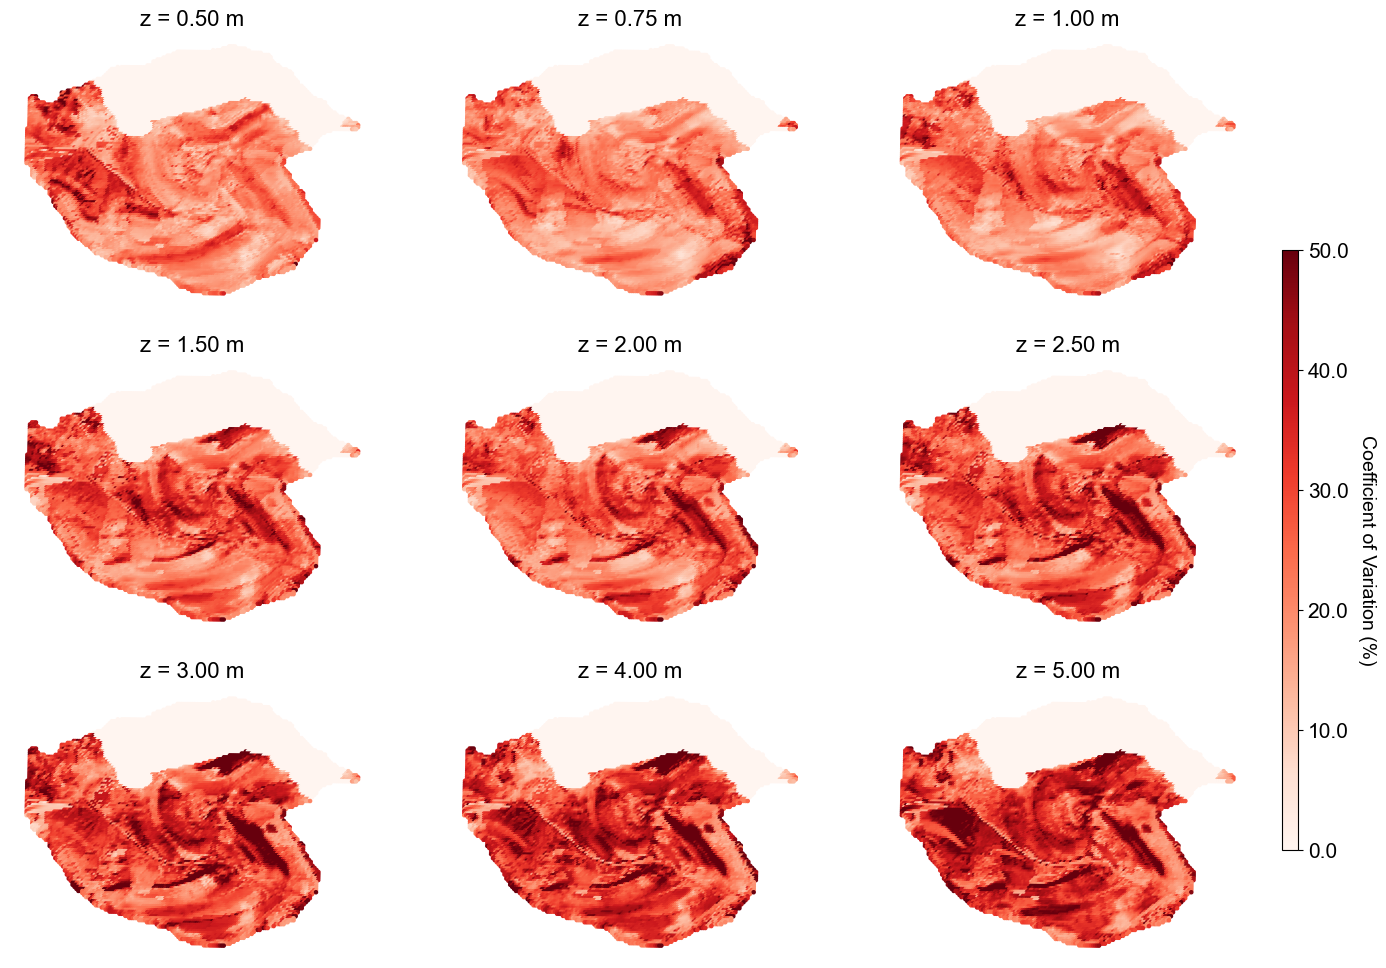

In [5]:
# Create the CV plot (Figure 2)
plt.figure(figsize=(16, 12))

# Create a custom colormap matching the image (white to orange to dark red)
colors_cv = ['#FFFFFF', '#FFF5E6', '#FFE0CC', '#FFCCB3', '#FFB399', 
             '#FF9980', '#FF8066', '#FF664D', '#FF4D33', '#E63900', '#CC3300', '#B32D00']
n_bins_cv = 256
cmap_cv = 'Reds'

# Calculate global CV range for consistent colorbar (CV is in percent)
all_cv_values = []
for depth in depths:
    cv_col = f'layer_{depth}m_cv_percent'
    if cv_col in filtered_data.columns:
        all_cv_values.extend(filtered_data[cv_col].dropna().values)

cv_vmin = 0
cv_vmax = 50 # Use 95th percentile to avoid outliers

print(f"CV range for plotting: {cv_vmin:.2f}% to {cv_vmax:.2f}%")

# Loop through all 9 subplots
for i, depth in enumerate(depths):
    # Create subplot (3 rows x 3 columns)
    ax = plt.subplot(3, 3, i+1)
    
    # Get CV data (in percent)
    cv_column = f'layer_{depth}m_cv_percent'
    
    # Create scatter plot with CV (NaN replaced with 0)
    sc = ax.scatter(filtered_data['x'], filtered_data['y'], 
                    c=filtered_data[cv_column], 
                    cmap=cmap_cv, alpha=1, s=5, 
                    vmin=cv_vmin, vmax=cv_vmax)
    
    # Remove all ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Add title
    ax.set_title(f'z = {depth} m', fontsize=16)
    
    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

# Add a colorbar
cbar_ax = plt.axes([0.92, 0.2, 0.01, 0.5])
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_label('Coefficient of Variation (%)', rotation=270, labelpad=20, fontsize=14)

# Set colorbar ticks
tick_positions = np.linspace(cv_vmin, cv_vmax, 6)
cbar.set_ticks(tick_positions)
cbar.set_ticklabels([f'{tick:.1f}' for tick in tick_positions])

# Save figure
plt.savefig('resistivity_uncertainty_CV.tif', dpi=300, bbox_inches='tight')
print("\nSaved figure as 'resistivity_uncertainty_CV.tif'")
plt.show()



Absolute uncertainty range: 0.00 to 145.58 Ω·m

Saved figure as 'resistivity_absolute_uncertainty.tif'


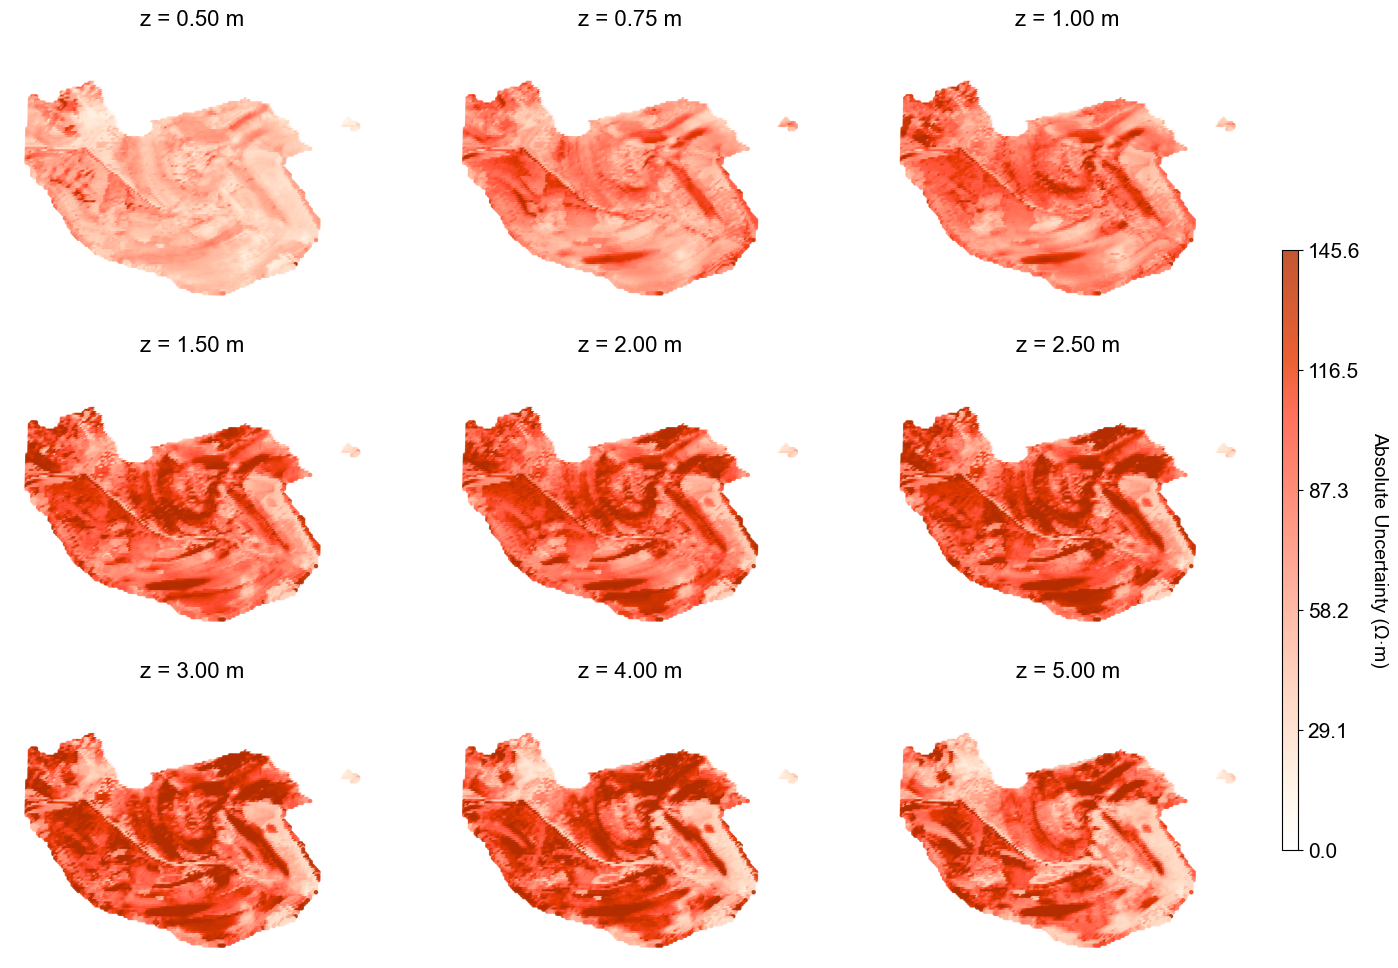

In [6]:
# Create absolute uncertainty plot for comparison (optional)
plt.figure(figsize=(16, 12))

# Use the same colormap for consistency
cmap_unc = LinearSegmentedColormap.from_list('unc_cmap', colors_cv, N=n_bins_cv)

# Calculate global uncertainty range using standard deviation uncertainty
all_unc_values = []
for depth in depths:
    unc_col = f'layer_{depth}m_uncertainty_std'
    if unc_col in filtered_data.columns:
        all_unc_values.extend(filtered_data[unc_col].dropna().values)

unc_vmin = 0
unc_vmax = np.percentile(all_unc_values, 95)

print(f"\nAbsolute uncertainty range: {unc_vmin:.2f} to {unc_vmax:.2f} Ω·m")

# Loop through all 9 subplots
for i, depth in enumerate(depths):
    ax = plt.subplot(3, 3, i+1)
    
    # Get uncertainty data (using standard deviation)
    unc_column = f'layer_{depth}m_uncertainty_std'
    
    # Create scatter plot (NaN replaced with 0)
    sc = ax.scatter(filtered_data['x'], filtered_data['y'], 
                    c=filtered_data[unc_column], 
                    cmap=cmap_unc, alpha=0.8, s=5, 
                    vmin=unc_vmin, vmax=unc_vmax)
    
    # Remove all ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Add title
    ax.set_title(f'z = {depth} m', fontsize=16)
    
    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

# Add colorbar
cbar_ax = plt.axes([0.92, 0.2, 0.01, 0.5])
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_label('Absolute Uncertainty (Ω·m)', rotation=270, labelpad=20, fontsize=14)

# Set colorbar ticks
tick_positions = np.linspace(unc_vmin, unc_vmax, 6)
cbar.set_ticks(tick_positions)
cbar.set_ticklabels([f'{tick:.1f}' for tick in tick_positions])

# Save figure
plt.savefig('resistivity_absolute_uncertainty.tif', dpi=300, bbox_inches='tight')
print("\nSaved figure as 'resistivity_absolute_uncertainty.tif'")
plt.show()


C:\Users\hchen117\AppData\Local\Temp\ipykernel_55284\2795081741.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 1])



Saved 3-panel figure as 'resistivity_uncertainty_CV_3panel.tif'


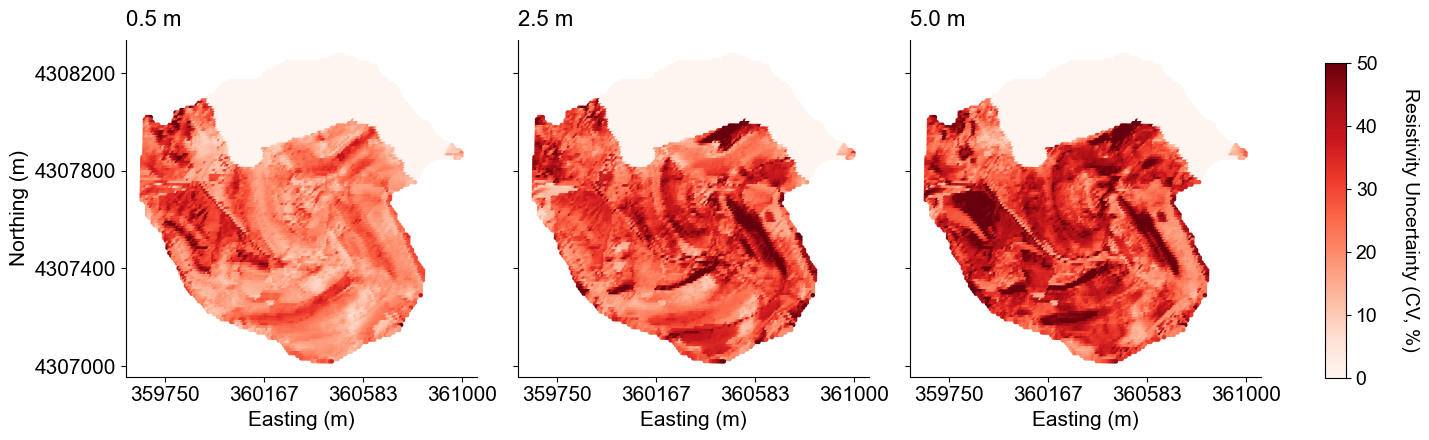


SUMMARY: Coefficient of Variation vs Absolute Uncertainty
Depth (m) Mean Resistivity (Ω·m) Mean Abs. Uncertainty (Ω·m) Mean CV (%)
     0.50                 248.85                       37.83       16.98
     0.75                 375.63                       55.00       16.19
     1.00                 412.66                       62.44       16.89
     1.50                 398.43                       72.59       20.38
     2.00                 427.74                       75.80       19.92
     2.50                 402.27                       80.23       22.49
     3.00                 374.79                       79.69       23.81
     4.00                 323.76                       75.06       25.26
     5.00                 278.66                       66.49       25.67

Key Observations:
1. At 0.5 m depth, absolute uncertainty is low (< 50 Ω·m) due to low resistivity
2. However, relative uncertainty (CV) reveals high variability at shallow depths
3. CV provides a more consiste

In [12]:
from matplotlib.ticker import FormatStrFormatter

import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
         'axes.labelsize': 15,
         'axes.titlesize':16,
         'xtick.labelsize':15,
         'ytick.labelsize':15}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

# Tick positions matching the reference style
x_ticks = [359750, 360167, 360583, 361000]
y_ticks = [4307000, 4307400, 4307800, 4308200]

# Create a 3-panel figure with shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5), sharey=True)

# Define the three depths to display (use 2 decimal places to match column names)
selected_depths = ['0.50', '2.50', '5.00']
depth_labels = ['0.5 m', '2.5 m', '5.0 m']

# Use the same colormap
cmap_3panel = 'Reds'

# Use the same CV range for consistency
cv_vmin_3panel = 0
cv_vmax_3panel = cv_vmax  # Same as the 9-panel figure

# Loop through the three subplots
for idx, (ax, depth, label) in enumerate(zip(axes, selected_depths, depth_labels)):
    # Get CV data (in percent)
    cv_column = f'layer_{depth}m_cv_percent'
    
    # Create scatter plot with CV (NaN replaced with 0.01)
    sc = ax.scatter(filtered_data['x'], filtered_data['y'], 
                    c=filtered_data[cv_column], 
                    cmap=cmap_3panel, alpha=1, s=5, 
                    vmin=cv_vmin_3panel, vmax=cv_vmax_3panel)
    
    # Add title at top
    ax.set_title(f'{label}', pad=10, loc='left', fontsize=16)
    
    # Set tick positions
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Format y-axis to show integers
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    # Add axis labels
    ax.set_xlabel('Easting (m)')
    if idx == 0:  # Only first panel gets y-label
        ax.set_ylabel('Northing (m)')

# Add a shared colorbar
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_label('Resistivity Uncertainty (CV, %)', rotation=270, labelpad=30, fontsize=14)

# Set colorbar ticks
tick_positions_3panel = np.linspace(cv_vmin_3panel, cv_vmax_3panel, 6)
cbar.set_ticks(tick_positions_3panel)
cbar.set_ticklabels([f'{tick:.0f}' for tick in tick_positions_3panel], fontsize=14)

# Layout adjustment
plt.tight_layout(rect=[0, 0, 0.93, 1])

# Save figure
plt.savefig('resistivity_uncertainty_CV_3panel.tif', dpi=300, bbox_inches='tight')
print("\nSaved 3-panel figure as 'resistivity_uncertainty_CV_3panel.tif'")
plt.show()

# Summary statistics comparing CV and absolute uncertainty
print("\n" + "="*80)
print("SUMMARY: Coefficient of Variation vs Absolute Uncertainty")
print("="*80)

summary_data = []
for depth in depths:
    resistivity_col = f'layer_{depth}m'
    uncertainty_col = f'layer_{depth}m_uncertainty_std'
    cv_col = f'layer_{depth}m_cv_percent'
    
    res_mean = filtered_data[resistivity_col].mean()
    unc_mean = filtered_data[uncertainty_col].mean()
    cv_mean = filtered_data[cv_col].mean()
    
    summary_data.append({
        'Depth (m)': depth,
        'Mean Resistivity (Ω·m)': f'{res_mean:.2f}',
        'Mean Abs. Uncertainty (Ω·m)': f'{unc_mean:.2f}',
        'Mean CV (%)': f'{cv_mean:.2f}'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("Key Observations:")
print("="*80)
print("1. At 0.5 m depth, absolute uncertainty is low (< 50 Ω·m) due to low resistivity")
print("2. However, relative uncertainty (CV) reveals high variability at shallow depths")
print("3. CV provides a more consistent measure across depths with varying resistivity")
print("4. This normalization makes it easier to compare uncertainty across different layers")
